# Урок 4. Формулируем задачу в терминах ML.

## Описание системы

В рамках данного проекта разрабатывается система для прогнозирования сроков строительства базовых станций сотовой связи.<br />
Отличительной особенностью системы является то, что на начальных этапах отсутствует вся информация о ключевых этапах технологического процесса.
1. На начальном этапе известны только параметры присущие самому планируемому объекту связи, такие как, место размещения, тип объекта, технологии, которые планируется строить, сопряженные объекты связи. По этим данным система прогнозирует предварительный срок строительства объекта связи. На данном этапе допустима точность прогнозирования в пределах одного квартала.
2. По мере работы над строительством базовой станции появляются даты важных производственных этапов. Каждый дополнительный шаг производственного процесса приводит к появлению дополнительного признака, который уточняет прогноз. Прогнозы с момента эатапа выдачи оборудования должны быть в пределах недели.
3. Кроме уже описанного с помощью системы должна быть предусмотрена возможность прогнозирования сроков каждого из этапов строительства.

## Загрузка и очистка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt

%matplotlib inline
SEED = 16

### Датасет

В качестве набора данных используем выгрузку из системы управления проектами за 2023, 2024 годы обфусцированную по чувствительным данным. 

In [3]:
df = pd.read_csv('o_19999.csv', index_col=0) # Загружаем данные
df.describe() # и просматриваем описание датасета

,year,INTEGRATION_5G,MONITORING_ASSEPTANCE_5G,COMMISSIONING_5G,idleft,idright,2g,3g,4g,rrl,a_index
count,19999.000000,0.0,0.0,0.0,1.999900e+04,1.999900e+04,7508.0,7413.0,19525.0,2557.0,19999.000000
mean,2023.343717,NaN,NaN,NaN,9.467952e+05,9.064633e+04,1.0,1.0,1.0,1.0,390847.358518
std,0.474960,NaN,NaN,NaN,1.892546e+06,5.914757e+05,0.0,0.0,0.0,0.0,189243.373878
min,2023.000000,NaN,NaN,NaN,1.140000e+02,1.440000e+02,1.0,1.0,1.0,1.0,61428.000000
25%,2023.000000,NaN,NaN,NaN,6.689000e+04,1.880000e+02,1.0,1.0,1.0,1.0,302527.000000
50%,2023.000000,NaN,NaN,NaN,2.844770e+05,1.880000e+02,1.0,1.0,1.0,1.0,392347.000000
75%,2024.000000,NaN,NaN,NaN,6.720395e+05,1.880000e+02,1.0,1.0,1.0,1.0,573728.000000
max,2024.000000,NaN,NaN,NaN,9.514423e+06,9.509531e+06,1.0,1.0,1.0,1.0,694921.000000


Датасет содержит 19999 строк, каждая строка соответствует работам по одному объекту связи. В описании видно, что есть неинформативные поля содержащие нулевые значания. Поля с нулевыми значениями удаляем.

In [5]:
NotNeededFields = ['INTEGRATION_5G', 'MONITORING_ASSEPTANCE_5G', 'COMMISSIONING_5G'] # все касается технологии 5g, её в 23, 24 году не строили
for fld in NotNeededFields:
    df = df.drop(fld, axis=1)

Смотрим на содержимое набора данных.

In [7]:
df.head()

,year,type_of_work,altername,contractor,date_start,date_fin,INTEGRATION_2G,INTEGRATION_3G,INTEGRATION_4G,INTEGRATION_TRM,...,PLAN_IS_READY,idleft,idright,2g,3g,4g,rrl,a_index,a_region,a_place
id,,,,,,,,,,,,,,,,,,,,,
1000040,2024,existing,work2334,contractor24,2022-08-26,2024-10-31,NaN,NaN,2024-10-31 12:02:00,NaN,...,NaN,1368441,188,NaN,NaN,1.0,NaN,139277,region14,urban
1000392,2023,new,work6981,contractor32,2022-09-12,2023-03-03,2023-03-02 15:39:00,NaN,2023-03-02 15:39:00,NaN,...,2023-02-15 08:23:00,53841,188,1.0,NaN,1.0,NaN,139086,region14,suburban
1000393,2023,new,work8181,contractor30,2022-09-12,2023-03-02,2023-03-01 16:22:00,NaN,2023-03-01 16:23:00,NaN,...,2023-02-14 10:16:00,53941,188,1.0,NaN,1.0,NaN,139100,region14,suburban
1000396,2023,new,work16610,contractor30,2022-09-12,2023-03-03,2023-03-03 13:21:00,NaN,2023-03-03 13:21:00,NaN,...,2023-02-15 08:23:00,54041,188,1.0,NaN,1.0,NaN,138822,region14,suburban
1000398,2023,new,work5393,contractor30,2022-09-12,2023-03-03,2023-03-02 15:39:00,NaN,2023-03-02 15:40:00,NaN,...,2023-02-15 08:24:00,54141,188,1.0,NaN,1.0,NaN,139181,region14,suburban


#### Описание полей датасета
<table>
    <tr>
        <th>Наименование поля</th>
        <th>Тип данных</th>
        <th>Тип признака</th>
        <th>Описание</th>
    </tr>
    <tr>
        <td>id</td>
        <td>Целочисленный</td>
        <td>Индекс</td>
        <td>Уникальный идентификатор работ</td>
    </tr>
    <tr>
        <td>year</td>
        <td>Целочисленный</td>
        <td>Числовой</td>
        <td>Год проведения работ</td>
    </tr>
    <tr>
        <td>type_of_work</td>
        <td>Текстовый</td>
        <td>Категориальный</td>
        <td>Тип работ, новое строительство или модернизация существующего</td>
    </tr>
    <tr>
        <td>altername</td>
        <td>Текстовый</td>
        <td>Категориальный</td>
        <td>Название работ</td>
    </tr>
    <tr>
        <td>contractor</td>
        <td>Текстовый</td>
        <td>Категориальный</td>
        <td>Название подрядной организации выполняющей работы</td>
    </tr>
    <tr>
        <td>date_start</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата регистрации работ в системе</td>
    </tr>
    <tr>
        <td>date_fin</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Отметка о дате окончания работ</td>
    </tr>
    <tr>
        <td>INTEGRATION_2G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата интеграции по технологиям</td>
    </tr>
    <tr>
        <td>INTEGRATION_3G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата интеграции по технологиям</td>
    </tr>
    <tr>
        <td>INTEGRATION_4G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата интеграции по технологиям</td>
    </tr>
    <tr>
        <td>INTEGRATION_TRM</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата интеграции по технологиям</td>
    </tr>
    <tr>
        <td>MONITORING_ASSEPTANCE_2G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата приемки готового объекта в мониторинг по технологиям</td>
    </tr>
    <tr>
        <td>MONITORING_ASSEPTANCE_3G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата приемки готового объекта в мониторинг по технологиям</td>
    </tr>
    <tr>
        <td>MONITORING_ASSEPTANCE_4G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата приемки готового объекта в мониторинг по технологиям</td>
    </tr>
    <tr>
        <td>MONITORING_ASSEPTANCE_TRM</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата приемки готового объекта в мониторинг по технологиям</td>
    </tr>
    <tr>
        <td>COMMISSIONING_2G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата ввода в эксплуатацию по технологиям</td>
    </tr>
    <tr>
        <td>COMMISSIONING_3G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата ввода в эксплуатацию по технологиям</td>
    </tr>
    <tr>
        <td>COMMISSIONING_4G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата ввода в эксплуатацию по технологиям</td>
    </tr>
    <tr>
        <td>EQUIPMENT_TRM</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности заявки на оборудования по компонентам объекта связи</td>
    </tr>
    <tr>
        <td>EQUIPMENT_ENERGO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности заявки на оборудования по компонентам объекта связи</td>
    </tr>
    <tr>
        <td>EQUIPMENT_STUFF</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности заявки на оборудования по компонентам объекта связи</td>
    </tr>
    <tr>
        <td>EQUIPMENT_RADIO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности заявки на оборудования по компонентам объекта связи</td>
    </tr>
    <tr>
        <td>CONSRACTION_READINESS</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата строительной готовности</td>
    </tr>
    <tr>
        <td>EQUIPMENT_PREPARED</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата комплектации оборудования</td>
    </tr>
    <tr>
        <td>INSTALL_BS</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата монтажа технологического оборудования</td>
    </tr>
    <tr>
        <td>INSTALL_ENERGO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата монтажа энергетического оборудования</td>
    </tr>
    <tr>
        <td>READY_FOR_WORK</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности к пуско-наладочным работам</td>
    </tr>
    <tr>
        <td>PARAMS_TRM</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности параметров для транспорта данных</td>
    </tr>
    <tr>
        <td>PARAMS_RADIO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности радиопараметров</td>
    </tr>
    <tr>
        <td>ASSERT_FOR_WORK</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности к пуско-наладочным работам</td>
    </tr>
    <tr>
        <td>ADR_PREPARE</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата начала работ по объекту</td>
    </tr>
    <tr>
        <td>TECH_TASK_TRM</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности технического задания по транспорту</td>
    </tr>
    <tr>
        <td>TECH_TASK_ENERGO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности технического задания по энергетике</td>
    </tr>
    <tr>
        <td>TECH_TASK_RADIO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности технического задания по радиочасти</td>
    </tr>
    <tr>
        <td>TECH_TASK_CONTRACTOR</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата передачи работ подрядчику</td>
    </tr>
    <tr>
        <td>CONTRACTOR_ACCEPTED</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата начала работ подрядчика</td>
    </tr>
    <tr>
        <td>idleft</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Уникальный идентификатор объекта связи</td>
    </tr>
    <tr>
        <td>idright</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Уникальный идентификатор сопряженного объекта связи</td>
    </tr>
    <tr>
        <td>2g</td>
        <td>Числовой</td>
        <td>Бинарный</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>3g</td>
        <td>Числовой</td>
        <td>Бинарный</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>4g</td>
        <td>Числовой</td>
        <td>Бинарный</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>rrl</td>
        <td>Числовой</td>
        <td>Бинарный</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>rrl</td>
        <td>Числовой</td>
        <td>Бинарный</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>a_index</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Признак места размещения объекта</td>
    </tr>
    <tr>
        <td>a_region</td>
        <td>Текстовый</td>
        <td>Категориальный</td>
        <td>Регион размещения объекта</td>
    </tr>
    <tr>
        <td>a_place</td>
        <td>Текстовый</td>
        <td>Бинарный</td>
        <td>Признак размещения объекта город или нет</td>
    </tr>
</table> 

In [9]:
#Типы полей
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, 1000040 to 1161382
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       19999 non-null  int64  
 1   type_of_work               19999 non-null  object 
 2   altername                  19999 non-null  object 
 3   contractor                 19999 non-null  object 
 4   date_start                 19999 non-null  object 
 5   date_fin                   19999 non-null  object 
 6   INTEGRATION_2G             7438 non-null   object 
 7   INTEGRATION_3G             7235 non-null   object 
 8   INTEGRATION_4G             19557 non-null  object 
 9   INTEGRATION_TRM            2591 non-null   object 
 10  MONITORING_ASSEPTANCE_2G   7418 non-null   object 
 11  MONITORING_ASSEPTANCE_3G   7217 non-null   object 
 12  MONITORING_ASSEPTANCE_4G   19538 non-null  object 
 13  MONITORING_ASSEPTANCE_TRM  2529 non-null   

Из предыдущего списка видно, что многие типы данных в полях не соответсвуют тем типам, которые в них содержатся. Проведем преобразование полей с датами к типу данных datetime. Поля с датами содержатся в столбцах имеющих названия записанные загравными буквами плюс к этим столбцам добавляются столбцы date_start, date_fin, их преобразуем отдельно:

In [11]:
#Все поля с заглавными буквами даты, плюс поля date_start, date_fin
fld = [x for x in df.columns if x==x.upper()] #+ ['date_start', 'date_fin']
for f in fld:
    df[f] = pd.to_datetime(df[f], format='%Y-%m-%d %H:%M:%S')
df['date_start'] = pd.to_datetime(df['date_start'], format='%Y-%m-%d')
df['date_fin'] = pd.to_datetime(df['date_fin'], format='%Y-%m-%d')

Заметим, что некоторые столбцы относятся к разным частям одного и того же этапа технологического процесса. Например, столбцы TECH_TASK_TRM, TECH_TASK_ENERGO, TECH_TASK_RADIO, TECH_TASK_CONTRACTOR фиксируют время готовности разных частей техничского задания, при этом для дальнейшей работы требуется все техничское задание целиком, поэтому набор этих столбцов можно преобразовать в одно поле содержащее самую большую дату. Объединим все такие поля и запишем их в результирующий датасет.

In [13]:
fields = {'tech': ['TECH_TASK_TRM', 'TECH_TASK_ENERGO', 'TECH_TASK_RADIO', 'TECH_TASK_CONTRACTOR'],
          'equipment': ['EQUIPMENT_TRM', 'EQUIPMENT_ENERGO', 'EQUIPMENT_STUFF', 'EQUIPMENT_RADIO'], 
          'integration': ['INTEGRATION_2G', 'INTEGRATION_3G', 'INTEGRATION_4G', 'INTEGRATION_TRM'], 
          'monitoring': ['MONITORING_ASSEPTANCE_2G', 'MONITORING_ASSEPTANCE_3G', 'MONITORING_ASSEPTANCE_4G', 'MONITORING_ASSEPTANCE_TRM'], 
          'commisioning': ['COMMISSIONING_2G', 'COMMISSIONING_3G', 'COMMISSIONING_4G'], 
          'params': ['PARAMS_TRM', 'PARAMS_RADIO']}
for key, val in fields.items():
    df[key+'_fin'] = df[val].max(axis=1)

Создадим набор полей содержащих промежутки времени между различными событиями технологического процесса.

In [15]:
df['delta_all'] = (df['date_fin'] - df['date_start'])/timedelta(days=1) #Все время работ в днях
df['delta_start'] = (df['ADR_PREPARE'] - df['date_start'])/timedelta(days=1) #Время от добавления в систему до начала работ
df['delta_tech'] = (df['tech_fin'] - df['ADR_PREPARE'])/timedelta(days=1) #Время от начала работ до готовности технической части
df['delta_spe'] = (df['equipment_fin'] - df['tech_fin'])/timedelta(days=1) #Время от готовности технической части до заказа оборудования
df['delta_equipment'] = (df['EQUIPMENT_PREPARED'] - df['equipment_fin'])/timedelta(days=1) #Время от начала работ до комплектации
df['delta_contractor'] = (df['CONTRACTOR_ACCEPTED'] - df['tech_fin'])/timedelta(days=1) #Время от готовности технической части до проектирования
df['delta_ready'] = (df['READY_FOR_WORK'] - df['EQUIPMENT_PREPARED'])/timedelta(days=1) #Время от комплектации до готовности к пуску
df['delta_params'] = (df['params_fin'] - df['READY_FOR_WORK'])/timedelta(days=1) #Время от готовности к пуску до готовности параметров
df['delta_integration'] = (df['integration_fin'] - df['params_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции
df['delta_monitoring'] = (df['monitoring_fin'] - df['integration_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции
df['delta_commisioning'] = (df['commisioning_fin'] - df['monitoring_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции

Оставляем копию датасета на данном этапе, для возможности дальнейшего анализа данных.

In [17]:
df_analysis = df.copy(deep=True)

Заменяем категориальные данные числовыми значениями для возможности использовать набор в задаче регрессии. 

In [19]:
fields = ['type_of_work', 'altername', 'contractor', 'a_region', 'a_place']
for fld in fields:
    print(fld)
    d = df[fld].value_counts().to_dict().keys()
    for idx, condition in enumerate(d):
        df.loc[df[fld] == condition, fld] = idx * 1.0
    df[fld] =  df[fld].astype(float)

type_of_work
altername
contractor
a_region
a_place


Удаяем поля, которые не будут участвовать в обучении модели.

In [21]:
fields = ['year', 'type_of_work', 'contractor', 'idleft', 'idright', 
          '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place',
          'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 
          'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration',
          'delta_monitoring', 'delta_commisioning', 'delta_all']
target = len(fields) - 1 #Целевое поле
df = df[fields]

Убираем пустые значения из результирующего набора данных.

In [23]:
empty_fields = df.columns[df.isnull().any()].tolist()
for fld in empty_fields:
    df[fld] = df[fld].fillna(0)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, 1000040 to 1161382
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                19999 non-null  int64  
 1   type_of_work        19999 non-null  float64
 2   contractor          19999 non-null  float64
 3   idleft              19999 non-null  int64  
 4   idright             19999 non-null  int64  
 5   2g                  19999 non-null  float64
 6   3g                  19999 non-null  float64
 7   4g                  19999 non-null  float64
 8   rrl                 19999 non-null  float64
 9   a_index             19999 non-null  int64  
 10  a_region            19999 non-null  float64
 11  a_place             19999 non-null  float64
 12  delta_start         19999 non-null  float64
 13  delta_tech          19999 non-null  float64
 14  delta_spe           19999 non-null  float64
 15  delta_equipment     19999 non-null  float64
 16  d

Результирующий набор содержит следующие поля:
<table>
    <tr>
        <th>Наименование поля</th>
        <th>Тип данных</th>
        <th>Тип признака</th>
        <th>Описание</th>
    </tr>
    <tr>
        <td>id</td>
        <td>Целочисленный</td>
        <td>Индекс</td>
        <td>Уникальный идентификатор работ</td>
    </tr>
    <tr>
        <td>year</td>
        <td>Целочисленный</td>
        <td>Числовой</td>
        <td>Год проведения работ</td>
    </tr>
    <tr>
        <td>contractor</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Номер подрядной организации</td>
    </tr>
    <tr>
        <td>idleft</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Уникальный идентификатор объекта связи</td>
    </tr>
    <tr>
        <td>idright</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Уникальный идентификатор сопряженного объекта связи</td>
    </tr>
    <tr>
        <td>2g</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>3g</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>4g</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>rrl</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>rrl</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>a_index</td>
        <td>Целочисленный</td>
        <td>Числовой</td>
        <td>Признак места размещения объекта</td>
    </tr>
    <tr>
        <td>a_region</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Регион размещения объекта</td>
    </tr>
    <tr>
        <td>a_place</td>
        <td>Вещественный</td>
        <td>Бинарный</td>
        <td>Признак размещения объекта город или нет</td>
    </tr>
    <tr>
        <td>a_place</td>
        <td>Вещественный</td>
        <td>Бинарный</td>
        <td>Признак размещения объекта город или нет</td>
    </tr>
    <tr>
        <td>delta_start</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от добавления в систему до начала работ</td>
    </tr>
    <tr>
        <td>delta_tech</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от начала работ до готовности технической части</td>
    </tr>
    <tr>
        <td>delta_spe</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности технической части до заказа оборудования</td>
    </tr>
    <tr>
        <td>delta_equipment</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от начала работ до комплектации</td>
    </tr> 
    <tr>
        <td>delta_contractor</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности технической части до проектирования</td>
    </tr>  
    <tr>
        <td>delta_ready</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от комплектации до готовности к пуску</td>
    </tr> 
    <tr>
        <td>delta_params</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности к пуску до готовности параметров</td>
    </tr> 
    <tr>
        <td>delta_integration</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности к пуску до интеграции</td>
    </tr> 
    <tr>
        <td>delta_monitoring</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности к пуску до интеграции</td>
    </tr> 
    <tr>
        <td>delta_all</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Все время работ в днях</td>
    </tr> 
</table>

## Анализ данных

In [27]:
from scipy.stats import f_oneway, shapiro, mannwhitneyu, probplot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns

**Проверим гипотезу:** средняя длительность строительства зависит от региона<br />
$H_0$: Среднее время строительства одинаково для всех регионов.<br />
$H_1$: Среднее время строительства зависит от региона и статистически значимо отличается от региона к региону.<br />
Проверяем на уровне значимости $\alpha = 0.05$ для двухсторонней альтернативы.

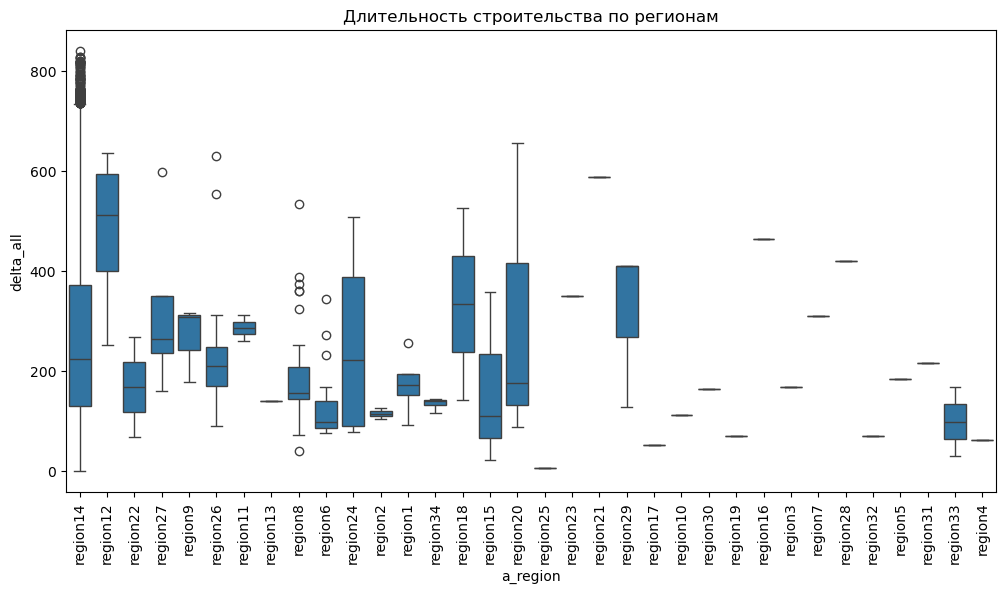

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_analysis, x='a_region', y='delta_all')
plt.xticks(rotation=90)
plt.title('Длительность строительства по регионам')
plt.show()

In [31]:
regions_groups = []
for name, group in df_analysis.groupby('a_region'):
    if group['delta_all'].std() > 0:
        regions_groups.append(group['delta_all'].values)
f_stat, p_value = f_oneway(*regions_groups)
print(f"ANOVA p-value: {p_value:.4f}")

ANOVA p-value: 0.0460


$p-value<0.05$ значит, отвергаем $H_0$ гипотезу, зависимость скорости строительства от региона есть. 

**Проверим гипотезу:** городские объекты (a_place = urban) строятся быстрее сельских<br />
$H_0$: Среднее время строительства одинаково для городских и загородных объектов связи.<br />
$H_1$: Среднее время строительства городских объектов быстрее загородных.<br />
Проверяем на уровне значимости $\alpha = 0.05$ для односторонеей альтернативы.

In [33]:
df_sample = df_analysis.sample(n=3000, random_state=SEED) # Выбираем 4000 случайных величины 
urban = df_sample[df_sample['a_place'] == 'urban']['delta_all'] # Отделяем выборки для городских
suburban = df_sample[df_sample['a_place'] == 'suburban']['delta_all'] # И загородных объектов
#Проверяем подчиняются ли выборки нормальному распределению с помощью критерия Шапиро-Уилка:
_, p_urban = shapiro(urban)
_, p_suburban = shapiro(suburban)
p_urban, p_suburban

(6.877098613682203e-30, 2.7731825683770586e-27)

Вычисленные значения критерия Шапиро-Уилка указывают на то, что данные распределены не нормально. Но, данная характеристика может давать неверные значения на больших выборках, дополнительно проверяем распределение с помощью q-q плот.

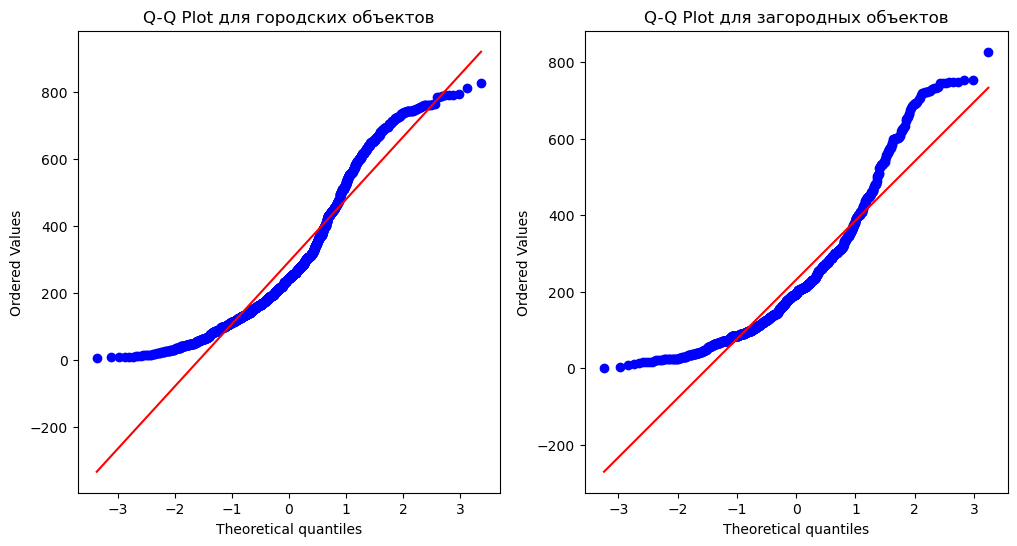

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
probplot(urban, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot для городских объектов')
probplot(suburban, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot для загородных объектов')
plt.show()

Данные распределены не нормально, на графиках тяжелые хвосты. Для проверки гипотезы используем критерий Манна-Уитни.

In [37]:
u_stat, p_value = mannwhitneyu(urban, suburban)
print(f"Mann-Whitney U p-value: {p_value:.4f}")

Mann-Whitney U p-value: 0.0000


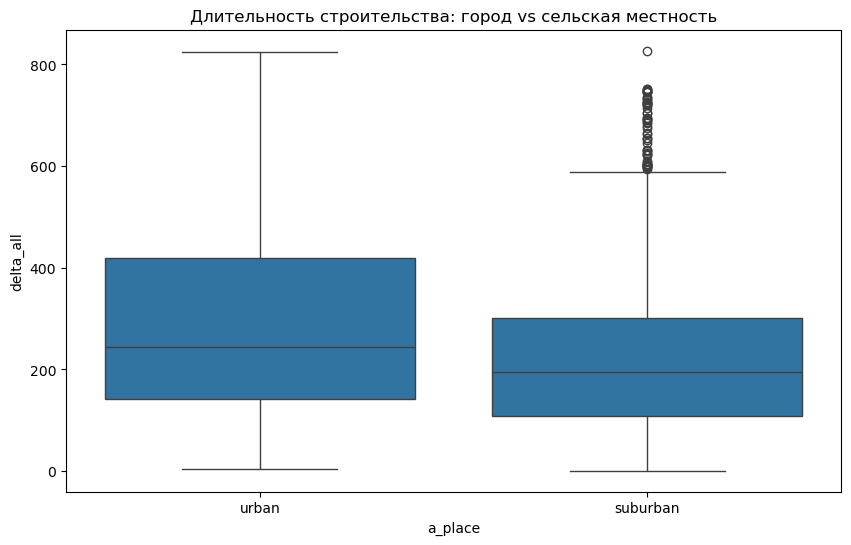

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='a_place', y='delta_all', data=df_sample)
plt.title("Длительность строительства: город vs сельская местность")
plt.show()

Разобъем данные на кластеры по признаку a_region.

In [41]:
NUM_CLUSTERS = 5

df_region = df.groupby('a_region').agg({
    'delta_all': ['mean', 'median'],
    '2g': 'sum',
    '3g': 'sum',
    '4g': 'sum',
    'rrl': 'sum',
    'a_place': 'count',
}).reset_index()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_region)
kmeans = KMeans(n_clusters=NUM_CLUSTERS)
df_region['cluster'] = kmeans.fit_predict(X_scaled)
#dbscan = DBSCAN(eps=0.5, min_samples=5)
#df_region['cluster'] = dbscan.fit_predict(X_scaled)

C:\Users\vladi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [43]:
df_region.cluster.value_counts().to_dict().keys()

dict_keys([1, 3, 4, 2, 0])

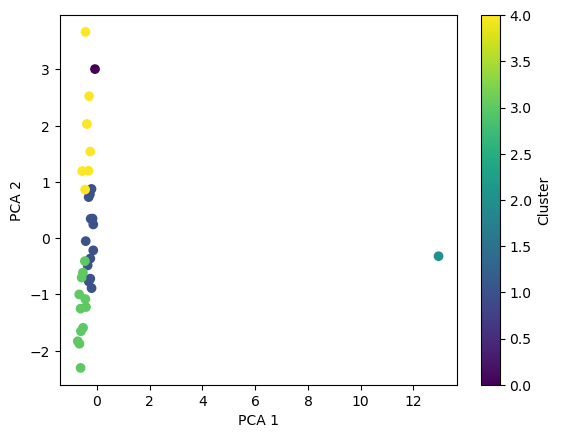

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_region['cluster'], cmap='viridis')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()

In [49]:
df_clustered = df.copy(deep=True)
df_clustered['cluster'] = 4
for cluster in df_region.cluster.value_counts().to_dict().keys():
    regions_in_cluster = df_region[df_region.cluster == cluster].a_region
    df_clustered.loc[df_clustered.a_region.isin(regions_in_cluster), 'cluster'] = cluster

Да, уж, наверное стоило это проверить с самого начала, но кластеры получились сильно не сбалансированными. Обучать модели по отдельности не кажется целесообразным. Попробуем этот прием на следующем этапе, если получится раздобыть данные из других регионов.

## Выбор метрик

В данной системе решаем задачу регрессии. Для этой задачи возможно использовать следующие метрики:<br />
1. MSE (Mean Squared Error) – Среднеквадратическая ошибка<br />
Расчитываем по формуле:
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$
- Чем меньше, тем лучше.
- Штрафует большие ошибки сильнее (из-за квадрата).
- Чувствительна к выбросам.
3. RMSE (Root Mean Squared Error) – Корень из среднеквадратической ошибки<br />
Расчитываем по формуле:
$$RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$
- Интерпретируем в тех же единицах, что и целевая переменная.
- Также чувствительна к выбросам.
5. MAE (Mean Absolute Error) – Средняя абсолютная ошибка<br />
Расчитываем по формуле:
$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$
- Менее чувствительна к выбросам, чем MSE/RMSE.
- Удобно интерпретировать (средняя ошибка в единицах целевой переменной).
7. R² (Коэффициент детерминации)<br />
Расчитываем по формуле:
$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$
- Показывает долю дисперсии, объяснённую моделью.
- Диапазон: от $-\infty$ - $+\infty$ до 1 (чем ближе к 1, тем лучше).
- Может быть отрицательным, если модель хуже, чем предсказание средним.
9. MAPE (Mean Absolute Percentage Error) – Средняя абсолютная процентная ошибка<br />
Расчитываем по формуле:
$$MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$$
- Выражается в процентах, удобно для бизнес-интерпретации.
- Не работает, если есть нулевые значения $y_i$.
11. MSLE (Mean Squared Logarithmic Error) – Среднеквадратическая логарифмическая ошибка<br />
Расчитываем по формуле:
$$MSLE = \frac{1}{n} \sum_{i=1}^{n} (\log(1 + y_i) - \log(1 + \hat{y}_i))^2$$
- Полезна, когда целевая переменная имеет экспоненциальный рост.
- Менее чувствительна к большим отклонениям, чем MSE.
13. Huber Loss – Комбинированная метрика (L1 + L2)<br />
Расчитываем по формуле:
$$L_\delta = 
\begin{cases} 
\frac{1}{2} (y_i - \hat{y}_i)^2, & \text{если } |y_i - \hat{y}_i| \leq \delta \\
\delta |y_i - \hat{y}_i| - \frac{1}{2} \delta^2, & \text{иначе}
\end{cases}$$
- Менее чувствительна к выбросам, чем MSE.
- Используется в оптимизации (например, в градиентном бустинге).

Планируется использовать несколько моделей и для общего их сравнения принято использовать одну из метрик: MSE, RMSE, MAE. Поскольку в данных содержится большое количество выбросов, что видно на графике отображающем яжщики с усами, то оптимальным вариантом из трех указанных метрик является MSE. 
В качестве второй метрики выбираем R2-score который объясняет долю дисперсии которую объясняет модель.
В ходе обучения модели будем стремиться уменьшить MAE и приблизить R2-score к единице.

## Выбор моделей

In [51]:
import optuna, joblib
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [88]:
metrics = []


Для обучения выберем три модели: линейную регрессию, случайны лес и xgboost.
Для каждой модели делаем каскадные предсказания, сначала предсказываем delta_start затем delta_tech и т.д.

### Линейная регрессия

In [90]:
#обучаем модель линейной регрессии имея только delta_start затем delta_tech и т.д.
lr_models = []
target = 22
features = 12
lr_metrics = []
for idx in range(features, target):
    print("********************************************")
    print(f"Шаг {idx - features + 1}")
    subfields = fields[:idx  + 1]
    print(f"Predict {fields[target]} with features {subfields}")
    X = df[subfields]
    y = df[fields[target]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
    lr_models.append(LinearRegression())
    lr_models[-1].fit(X_train, y_train)
    y_pred = lr_models[-1].predict(X_test)
    print("Коэффициенты модели:", lr_models[-1].coef_)
    print("Свободный член (intercept):", lr_models[-1].intercept_)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    print("Средняя абсолютная ошибка (MAE):", MAE)
    print("Коэффициент детерминации (R²):", R2)
    lr_metrics.append((MAE, R2))

metrics.append(lr_metrics)

********************************************
Шаг 1
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start']
Коэффициенты модели: [ 2.01490510e+02 -9.39386451e+01  1.82764169e+00 -3.81857317e-06
 -8.11998983e-07  7.96623308e+01  7.88056806e+01  1.11588910e+02
  3.36223564e+01  4.76586848e-05 -1.75170006e+00 -1.15964283e+01
  7.26663247e-01]
Свободный член (intercept): -407627.67236189585
Средняя абсолютная ошибка (MAE): 92.60901328192683
Коэффициент детерминации (R²): 0.5788945388521274
********************************************
Шаг 2
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech']
Коэффициенты модели: [ 8.28588001e+01 -3.52882739e+01  9.86206501e-01 -2.00523937e-06
 -2.38876752e-06  3.60101564e+01  3.54125701e+01  5.46365371e+01
 -5.57026564e+00  

In [59]:
#Сохраняем модели чтобы не ждать их обучения
for idx in range(features, len(fields) - 1):
    joblib.dump(lr_models[idx - features], f'lr_model_{fields[idx]}.pkl')

### Случайный лес

Для случайного леса используем optuna для подбора оптимальных параметров.

In [63]:
rf_models = [] # В список сохраняем обученные модели с лучшими параметрами
target = 22 # Все поля хрнятся в списке fields, переменная target указывает на целевой атрибут
features = 12
rf_metrics = []
# Подготавливаем необхоодимые функции
# Для подбора параметров 
def objective(trial, X_train, X_test, y_train, y_test):
    """Функция для подбора параметров"""
    # Определяем пространство поиска параметров
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Создаем и обучаем модель
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    # Делаем предсказания и вычисляем метрики
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae # Можно оптимизировать по MAE или R2 - выбираем MAE

def RFOptimazeAndLearn(step, feature, rf_model):
    idx = feature + step - 1
    print("********************************************")
    print(f"Шаг {step}")
    subfields = fields[:idx + 1]
    print(f"Predict delta_all with features {subfields}")
    X = df[subfields]
    y = df[fields[target]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
        
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test), n_trials=50, show_progress_bar=False)
    best_params = study.best_params
    print(best_params)
        
    rf_model.append(RandomForestRegressor(**best_params, random_state=42, n_jobs=-1))
    rf_model[-1].fit(X_train, y_train)
    y_pred = rf_model[-1].predict(X_test)
    MAE, R2 = mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
    print("Средняя абсолютная ошибка (MAE):", MAE)
    print("Коэффициент детерминации (R²):", R2)
    return MAE, R2

In [ ]:
rf_metrics.append( RFOptimazeAndLearn(1, features, rf_models) ) # Предсказываем delta_all имея только delta_start

[I 2025-06-27 07:57:10,524] A new study created in memory with name: no-name-49298a7c-39d2-43a4-940b-1a10f7e1c19b


********************************************
Шаг 1
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start']


In [66]:
rf_metrics.append( RFOptimazeAndLearn(2, features, rf_models) ) # Добавляем delta_tech

[I 2025-06-27 01:28:00,867] A new study created in memory with name: no-name-70bd1b29-7afc-4a7b-9d5e-b3cbdcca1b66


********************************************
Шаг 2
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning', 'delta_all']


[I 2025-06-27 01:28:31,323] Trial 0 finished with value: 0.01620505262062918 and parameters: {'n_estimators': 816, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.01620505262062918.
[I 2025-06-27 01:29:15,152] Trial 1 finished with value: 0.011718642641076797 and parameters: {'n_estimators': 1211, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.011718642641076797.
[I 2025-06-27 01:29:21,740] Trial 2 finished with value: 8.636571469143204 and parameters: {'n_estimators': 634, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.011718642641076797.
[I 2025-06-27 01:29:24,133] Trial 3 finished with value: 22.16133001889923 and parameters: {'n_estimators': 402, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_feat

{'n_estimators': 560, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}
Средняя абсолютная ошибка (MAE): 0.009509151785714336
Коэффициент детерминации (R²): 0.9999992058504813


In [67]:
rf_metrics.append( RFOptimazeAndLearn(3, features, rf_models) ) # Добавляем delta_spe 

[I 2025-06-27 02:08:39,551] A new study created in memory with name: no-name-5d2b0f4a-dd3b-407e-bd98-5c739a3819fd


********************************************
Шаг 3
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning', 'delta_all']


[I 2025-06-27 02:08:52,996] Trial 0 finished with value: 8.799187183804126 and parameters: {'n_estimators': 858, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 8.799187183804126.
[I 2025-06-27 02:09:03,838] Trial 1 finished with value: 22.201306879774407 and parameters: {'n_estimators': 1597, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 8.799187183804126.
[I 2025-06-27 02:09:05,028] Trial 2 finished with value: 56.540660654637 and parameters: {'n_estimators': 232, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 8.799187183804126.
[I 2025-06-27 02:09:36,685] Trial 3 finished with value: 0.013738049095608407 and parameters: {'n_estimators': 516, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 

{'n_estimators': 1905, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 0.008673884514435156
Коэффициент детерминации (R²): 0.9999999307630457


In [68]:
rf_metrics.append( RFOptimazeAndLearn(4, features, rf_models) ) # Добавляем delta_equipment 

[I 2025-06-27 02:52:07,081] A new study created in memory with name: no-name-3c187f34-81ec-4617-b114-2f4d14acfe8d


********************************************
Шаг 4
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning', 'delta_all']


[I 2025-06-27 02:52:23,769] Trial 0 finished with value: 11.428781228248274 and parameters: {'n_estimators': 1614, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 11.428781228248274.
[I 2025-06-27 02:52:44,684] Trial 1 finished with value: 6.3009148773208965 and parameters: {'n_estimators': 938, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 6.3009148773208965.
[I 2025-06-27 02:53:07,773] Trial 2 finished with value: 0.009335832141319852 and parameters: {'n_estimators': 516, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.009335832141319852.
[I 2025-06-27 02:53:14,279] Trial 3 finished with value: 18.280299352542986 and parameters: {'n_estimators': 820, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_feat

{'n_estimators': 1734, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 0.008706026528259357
Коэффициент детерминации (R²): 0.9999999299227789


In [69]:
rf_metrics.append( RFOptimazeAndLearn(5, features, rf_models) ) # Добавляем delta_contractor 

[I 2025-06-27 03:33:59,833] A new study created in memory with name: no-name-83bb5563-b956-4800-87b1-17fd167adb5b


********************************************
Шаг 5
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning', 'delta_all']


[I 2025-06-27 03:34:19,479] Trial 0 finished with value: 7.958188160732329 and parameters: {'n_estimators': 1490, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 7.958188160732329.
[I 2025-06-27 03:35:15,964] Trial 1 finished with value: 0.016879369719828424 and parameters: {'n_estimators': 1393, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.016879369719828424.
[I 2025-06-27 03:35:59,575] Trial 2 finished with value: 0.02595489353582966 and parameters: {'n_estimators': 1101, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.016879369719828424.
[I 2025-06-27 03:36:05,506] Trial 3 finished with value: 8.708145616440989 and parameters: {'n_estimators': 474, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_fea

{'n_estimators': 800, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 0.009204032776252938
Коэффициент детерминации (R²): 0.9999998983733883


In [70]:
rf_metrics.append( RFOptimazeAndLearn(6, features, rf_models) ) # Добавляем delta_ready 

[I 2025-06-27 04:00:10,351] A new study created in memory with name: no-name-f782d325-74a8-4a40-8375-d31063496e46


********************************************
Шаг 6
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning', 'delta_all']


[I 2025-06-27 04:00:14,892] Trial 0 finished with value: 10.371056949577738 and parameters: {'n_estimators': 376, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 10.371056949577738.
[I 2025-06-27 04:00:43,075] Trial 1 finished with value: 7.418639415216232 and parameters: {'n_estimators': 1853, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 7.418639415216232.
[I 2025-06-27 04:00:46,830] Trial 2 finished with value: 27.57222345691437 and parameters: {'n_estimators': 556, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 7.418639415216232.
[I 2025-06-27 04:02:34,021] Trial 3 finished with value: 0.02002345819505502 and parameters: {'n_estimators': 1679, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features'

{'n_estimators': 115, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}
Средняя абсолютная ошибка (MAE): 0.009108695652173957
Коэффициент детерминации (R²): 0.9999992658700387


In [71]:
rf_metrics.append( RFOptimazeAndLearn(7, features, rf_models) ) # Добавляем delta_params 

[I 2025-06-27 04:25:21,637] A new study created in memory with name: no-name-899d8422-f65d-484f-a53a-9b8e624d3fad


********************************************
Шаг 7
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning', 'delta_all']


[I 2025-06-27 04:25:52,140] Trial 0 finished with value: 7.735489724228322 and parameters: {'n_estimators': 1734, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 7.735489724228322.
[I 2025-06-27 04:26:14,969] Trial 1 finished with value: 11.070912941173843 and parameters: {'n_estimators': 1580, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 7.735489724228322.
[I 2025-06-27 04:26:35,778] Trial 2 finished with value: 8.64216533881956 and parameters: {'n_estimators': 1697, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 7.735489724228322.
[I 2025-06-27 04:26:52,222] Trial 3 finished with value: 2.7899689898961793 and parameters: {'n_estimators': 433, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features'

{'n_estimators': 1868, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 0.009119770573004964
Коэффициент детерминации (R²): 0.999999917966022


In [78]:
rf_metrics.append( RFOptimazeAndLearn(8, features, rf_models) ) # Добавляем delta_integration 

[I 2025-06-27 05:33:20,558] A new study created in memory with name: no-name-0b321612-b7c1-48e4-9852-cfe80682c5b4


********************************************
Шаг 8
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning', 'delta_all']


[I 2025-06-27 05:34:16,012] Trial 0 finished with value: 0.016848983809796044 and parameters: {'n_estimators': 1449, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.016848983809796044.
[I 2025-06-27 05:34:34,404] Trial 1 finished with value: 6.312021370766175 and parameters: {'n_estimators': 915, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.016848983809796044.
[I 2025-06-27 05:34:38,545] Trial 2 finished with value: 43.22618816383591 and parameters: {'n_estimators': 618, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.016848983809796044.
[I 2025-06-27 05:34:52,326] Trial 3 finished with value: 18.027119832026248 and parameters: {'n_estimators': 1321, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_f

{'n_estimators': 584, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 0.009096746575341513
Коэффициент детерминации (R²): 0.9999999290646145


In [80]:
rf_metrics.append( RFOptimazeAndLearn(9, features, rf_models) ) # Добавляем delta_monitoring 

[I 2025-06-27 05:54:13,444] A new study created in memory with name: no-name-02962764-4e24-46c2-a057-2edd6724d3cf


********************************************
Шаг 9
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning', 'delta_all']


[I 2025-06-27 05:54:20,684] Trial 0 finished with value: 21.86142942222664 and parameters: {'n_estimators': 1020, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 21.86142942222664.
[I 2025-06-27 05:54:29,355] Trial 1 finished with value: 9.65937510165009 and parameters: {'n_estimators': 799, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 9.65937510165009.
[I 2025-06-27 05:55:16,012] Trial 2 finished with value: 0.009900977730606862 and parameters: {'n_estimators': 1106, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.009900977730606862.
[I 2025-06-27 05:55:24,961] Trial 3 finished with value: 10.032331877610561 and parameters: {'n_estimators': 606, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_feature

{'n_estimators': 734, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 0.009151132534774748
Коэффициент детерминации (R²): 0.9999999007962862


In [82]:
rf_metrics.append( RFOptimazeAndLearn(10, features, rf_models) ) # Добавляем delta_commisioning   

[I 2025-06-27 06:21:15,505] A new study created in memory with name: no-name-5f06a3a2-8955-444e-8ef7-1a6f4d06578a


********************************************
Шаг 10
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning', 'delta_all']


[I 2025-06-27 06:21:20,958] Trial 0 finished with value: 0.08743062322792307 and parameters: {'n_estimators': 188, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.08743062322792307.
[I 2025-06-27 06:22:41,872] Trial 1 finished with value: 0.010215644190406305 and parameters: {'n_estimators': 1996, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.010215644190406305.
[I 2025-06-27 06:23:00,103] Trial 2 finished with value: 11.246256282403108 and parameters: {'n_estimators': 1317, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.010215644190406305.
[I 2025-06-27 06:23:04,084] Trial 3 finished with value: 43.08396241055932 and parameters: {'n_estimators': 690, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_fea

{'n_estimators': 1900, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 0.008677039473684972
Коэффициент детерминации (R²): 0.999999930771114


In [84]:
metrics.append(rf_metrics) # Сохраняем полученные метрики для сравнения
for idx in range(features, len(fields)-1):
    joblib.dump(rf_models[idx - features], f'rf_model_{fields[idx]}.pkl')

In [86]:
metrics

[[(92.60901328192683, 0.5788945388521274),
  (51.14791219035048, 0.8426334666818462),
  (33.55749497235551, 0.9254578819209702),
  (31.433562630135796, 0.9343916069226539),
  (31.390798707402777, 0.9345413414858575),
  (27.970262602693133, 0.9456061592944377),
  (27.000443264283682, 0.9491820260755879),
  (20.316744496020785, 0.9605875857053913),
  (20.216525302316672, 0.9616519224156802),
  (15.918057633157867, 0.971010271776624)],
 [(46.99191948279011, 0.8607146191312851),
  (0.009509151785714336, 0.9999992058504813),
  (0.008673884514435156, 0.9999999307630457),
  (0.008706026528259357, 0.9999999299227789),
  (0.009204032776252938, 0.9999998983733883),
  (0.009108695652173957, 0.9999992658700387),
  (0.009119770573004964, 0.999999917966022),
  (0.009096746575341513, 0.9999999290646145),
  (0.009151132534774748, 0.9999999007962862),
  (0.008677039473684972, 0.999999930771114)]]

### XGBoost

In [ ]:
#обучаем модель линейной регрессии для каскадных предсказаний, сначала предсказываем delta_start затем delta_tech и т.д.
ROUNDS = 100
xgb_models = []
target = 22
features = 12
xgb_metrics = []
params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.5,
    'lambda': 1.0,
    'seed': 16
}
# подготавливаем необходимые функции
def objective(trial, X, y):
    # Определяем пространство поиска параметров
    params = {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'lambda': trial.suggest_float('lambda', 0, 1),
        'seed': 16
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    num_round = ROUNDS
    
    model = xgb.train(
        params,
        dtrain,
        num_round,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    y_pred = model.predict(dtest)
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

def XGBOptimazeAndLearn(step, feature, rf_model, params):
    idx = feature + step - 1
    print("********************************************")
    print(f"Шаг {step}")
    subfields = fields[:idx + 1]
    print(f"Predict delta_all with features {subfields}")
    X = df[subfields]
    y = df[fields[target]]

    # Оптимизация гиперпараметров с помощью Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=50)

    print(f"Лучшие параметры для {fields[idx]}:")
    print(study.best_params)
    print(f"Лучший MAE: {study.best_value:.4f}")

    # Обучение модели с лучшими параметрами
    best_params = study.best_params
    best_params['objective'] = 'reg:absoluteerror'
    best_params['eval_metric'] = 'mae'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    
    num_round = 800
    
    xgb_models.append(xgb.train(
                                best_params,
                                dtrain,
                                num_round,
                                evals=evals,
                                early_stopping_rounds=50,  # Увеличим терпение для ранней остановки
                                verbose_eval=20
                            )
                        )
    y_pred = xgb_models[-1].predict(dtest)
    print("\nМетрики качества:")
    MAE, R2 = mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
    print(f"Средняя абсолютная ошибка (MAE): {MAE}")
    print(f"Коэффициент детерминации (R²): {R2}")
    return MAE, R2

In [ ]:
xgb_metrics.append( XGBOptimazeAndLearn(1, features, xgb_models, params) ) # Предсказываем delta_all только с delta_start

In [ ]:
xgb_metrics.append( XGBOptimazeAndLearn(2, features, xgb_models, params) ) # Добавляем delta_tech

In [ ]:
xgb_metrics.append( XGBOptimazeAndLearn(3, features, xgb_models, params) ) # Добавляем delta_spe 

In [ ]:
xgb_metrics.append( XGBOptimazeAndLearn(4, features, xgb_models, params) ) # Добавляем delta_equipment 

In [ ]:
xgb_metrics.append( XGBOptimazeAndLearn(5, features, xgb_models, params) ) # Добавляем delta_contractor

In [ ]:
xgb_metrics.append( XGBOptimazeAndLearn(6, features, xgb_models, params) ) # Добавляем delta_ready 

In [ ]:
xgb_metrics.append( XGBOptimazeAndLearn(7, features, xgb_models, params) ) # Добавляем delta_params 

In [ ]:
xgb_metrics.append( XGBOptimazeAndLearn(8, features, xgb_models, params) ) # Добавляем delta_integration 

In [ ]:
xgb_metrics.append( XGBOptimazeAndLearn(9, features, xgb_models, params) ) # Добавляем delta_monitoring 

In [ ]:
xgb_metrics.append( XGBOptimazeAndLearn(10, features, xgb_models, params) ) # Добавляем delta_commisioning 

In [ ]:
metrics.append(xgb_metrics) # Сохраняем метрики для сравнения
for idx in range(features, len(fields)-1):
    joblib.dump(xgb_models[idx - features], f'xgb_model_{fields[idx]}.pkl')

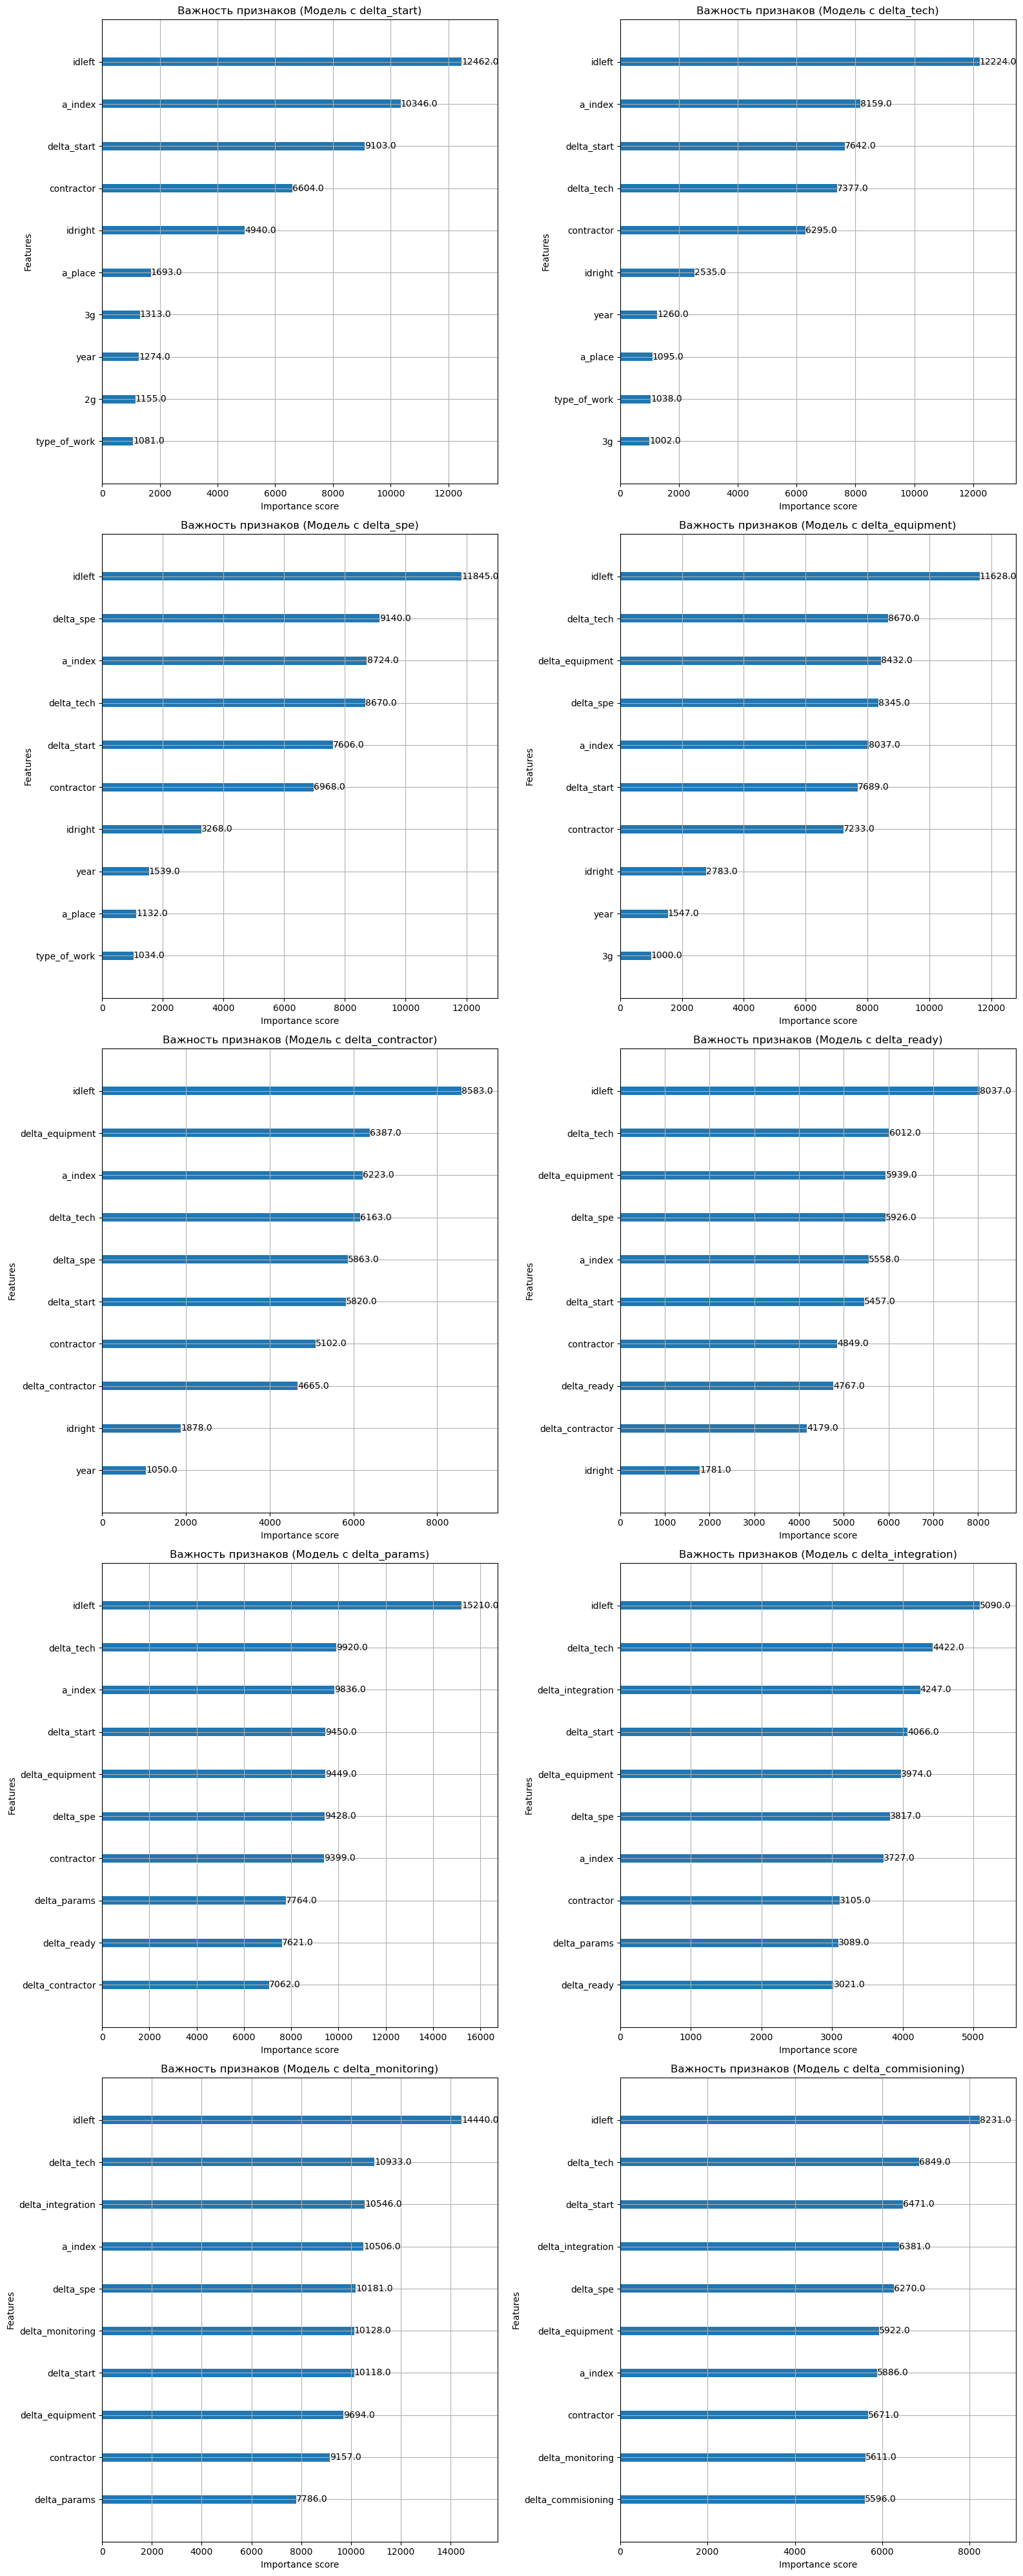

In [400]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 40))

# Проходим по всем моделям и осям
for idx, (model, ax) in enumerate(zip(xgb_models, axes.flatten())):
    xgb.plot_importance(model, ax=ax, max_num_features=10)
    ax.set_title(f"Важность признаков (Модель с {fields[idx + features]})")

# Убираем лишние оси, если моделей меньше чем subplots
if len(xgb_models) < 5*2:
    for j in range(len(xgb_models), 5*2):
        axes.flatten()[j].axis('off')

plt.tight_layout()
plt.show()

## Оценка метрик качества

In [429]:
models = ['LinearRegression', 'RandomForest', 'XGBoost']
rows = []
for model, model_data in zip(models, metrics):
    rows.append({'model': model, 'metrics': 'MAE', **{f'{fields[features+i]}': val[0] for i, val in enumerate(model_data)}})
    rows.append({'model': model, 'metrics': 'R2', **{f'{fields[features+i]}': val[1] for i, val in enumerate(model_data)}})
result_df = pd.DataFrame(rows)
result_df

,model,metrics,delta_start,delta_tech,delta_spe,delta_equipment,delta_contractor,delta_ready,delta_params,delta_integration,delta_monitoring,delta_commisioning
0,LinearRegression,MAE,41.291735,85.715309,43.777022,23.926801,35.297903,19.017423,9.582669,23.002750,13.001823,21.315706
1,LinearRegression,R2,0.033742,0.410346,0.174047,0.060712,0.161009,0.301110,0.062778,0.126154,0.059631,0.958000
2,RandomForest,MAE,19.747132,50.473928,24.382679,15.292584,17.619653,10.644404,6.201810,16.408691,10.645353,18.840243
3,RandomForest,R2,0.419450,0.682934,0.643572,0.478673,0.533090,0.597352,0.248793,0.326283,0.137117,0.964989
4,XGBoost,MAE,17.276822,49.381577,23.633515,14.010517,17.589006,9.540118,5.278583,14.363005,7.553742,15.335651
5,XGBoost,R2,0.444247,0.675097,0.585349,0.517438,0.404774,0.709134,0.171806,0.185163,0.128402,0.970703
